# Predictive Brain Tumor Image AI Project - Preprocessing & Modeling

To make an image-processing brain tumor predictive model to automate on scale.

# The Plan

The overall goal is to make a prediction model that classifies if the model as brain tumor or not. 

#################################################################

Brain MRI info
- Glioma: A type of cancer arising from glial cells in the brain or spinal cord.
- Meningioma: Usually a benign tumor from the meninges; rarely malignant.
- Notumor: Means no tumor was found.
- Pituitary: Refers to the gland; tumors (mostly benign) can form, rarely cancerous.

#################################################################

The Plan:
- the end goal is to make a model where you input image data of Brain MRI and will classify either Cancer or No Cancer.
- We will be experimenting with different data sets and different model methods.
- one idea is 4 classes (glioma, meningioma, notumor, pituitary), and have the model try to classify the 4 classes which will will then be organized into 2 classification (cancer or not).
    - The idea is that the model will place more effort in separating into 4 classification, which already has balanced data and thus be more accurate. And then we can add another layer to organized the results of 4 classifications into the 2 classifications of either cancer or no cancer.
- Other idea is to have the Glioma class as cancer and the rest of the classes merged as not cancer. Then train the AI to classify between the 2 classes. But this will create a data imbalance issue that we will have to address.
- And each of those 2 ideas will have 2 data sets each as one is either using the non-augmented data (~6K image data so small and use pytorches random augmentation) or the augmented data (~ 87K image data)

#################################################################

The 4 Datasets:
|               | 4 classes balanced | 2 classes imbalanced|
|---------------|--------------------|---------------------|
| Non-Augmented | Dataset 1          | Dataset 2           |
| Augmented     | Dataset 3          | Dataset 4           |

#################################################################

Cross validation:
- will use k-fold and divide up each dataset into multiple folds to make it easier to cross validate

#################################################################

Folder Structure:

We will most likely be using pytorch and it's dataloader, and that system likes to have subfolders which the data loader will use the subfolders name to apply labels to each of the images during training and testing.

#################################################################

# Initial Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image as PILImage 
# using from PIL import Image as PILImage to count takes too long now as will try to also validate each image. We are assuming all the images are validated and are in correct format from Data Wrangling and EDA steps.

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from torch.utils.data import WeightedRandomSampler, DataLoader
from sklearn.utils import resample

import torch.nn as nn
import torch.nn.functional as F


from collections import Counter

In [2]:
# Caching the image data paths

image_dataset1_4_na_path = "./ImageData-Merge_Scaled_Cropped_Resize2"
image_dataset2_2_na_path = "./ImageData-Merge_Scaled_Cropped_Resize3"
image_dataset3_4_a_path = "./ImageData-Merge_Scaled_Cropped_Resize2_Augmented1"
image_dataset4_2_a_path = "./ImageData-Merge_Scaled_Cropped_Resize2_Augmented2"

# Data Imbalance

## Image Distribution

In [3]:
# Bar Graph Code
def quick_plot_bar_graph(categories, values, figsize = (10, 6), title='Image Counts with Percentages', xlabel='Brain Tumor Types', ylabel='Count'):
    """
    Plots a bar graph with counts and percentages displayed on top of the bars.

    Parameters:
    - categories: List of category names (x-axis).
    - values: List of corresponding values (heights of the bars).
    """
    # Calculate total for percentage calculation
    total = sum(values)
    
    # Plot the bar graph
    plt.figure(figsize=figsize)
    bars = plt.bar(categories, values, color='skyblue')

    # Add count and percentage on top of each bar
    for bar, value in zip(bars, values):
        height = bar.get_height()
        percentage = (value / total) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, height, 
                 f'{value}\n({percentage:.1f}%)', 
                 ha='center', va='bottom', fontsize=10)

    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # Show the plot
    plt.show()

Glioma: 1619
Meningioma: 1634
NoTumor: 1726
Pituitary: 1740


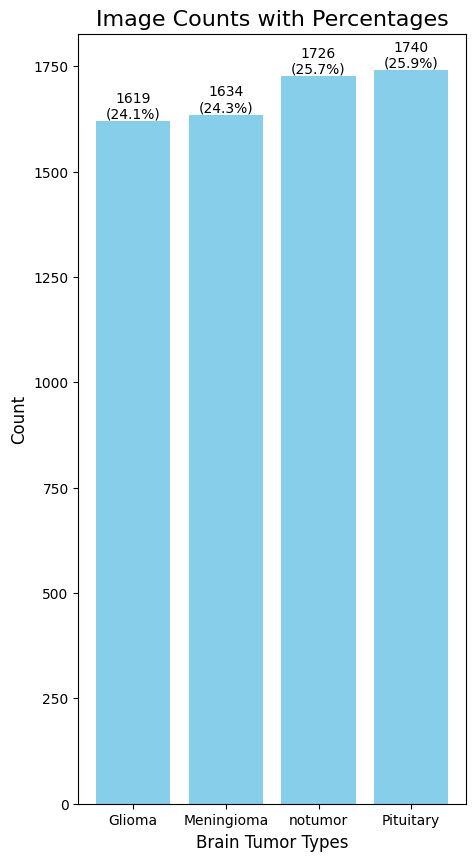

In [4]:
# Dataset 1 - 4 classes non augmented

# Load dataset
dataset = datasets.ImageFolder(root=image_dataset1_4_na_path)

# Get class distribution
class_counts = Counter(dataset.targets)

# Map indices to class names
class_names = dataset.classes

# Extract counts into variables
glioma_count_4_na = class_counts[dataset.class_to_idx['glioma']]
meningioma_count_4_na = class_counts[dataset.class_to_idx['meningioma']]
notumor_count_4_na = class_counts[dataset.class_to_idx['notumor']]
pituitary_count_4_na = class_counts[dataset.class_to_idx['pituitary']]

# Print counts
print(f"Glioma: {glioma_count_4_na}")
print(f"Meningioma: {meningioma_count_4_na}")
print(f"NoTumor: {notumor_count_4_na}")
print(f"Pituitary: {pituitary_count_4_na}")

quick_plot_bar_graph(['Glioma','Meningioma','notumor','Pituitary'], [glioma_count_4_na,meningioma_count_4_na,notumor_count_4_na,pituitary_count_4_na], figsize = (5, 10), title='Image Counts with Percentages', xlabel='Brain Tumor Types', ylabel='Count')

# There is not much data imbalance so it's good to go with this data set. 

Cancer: 1619
NonCancer: 5100


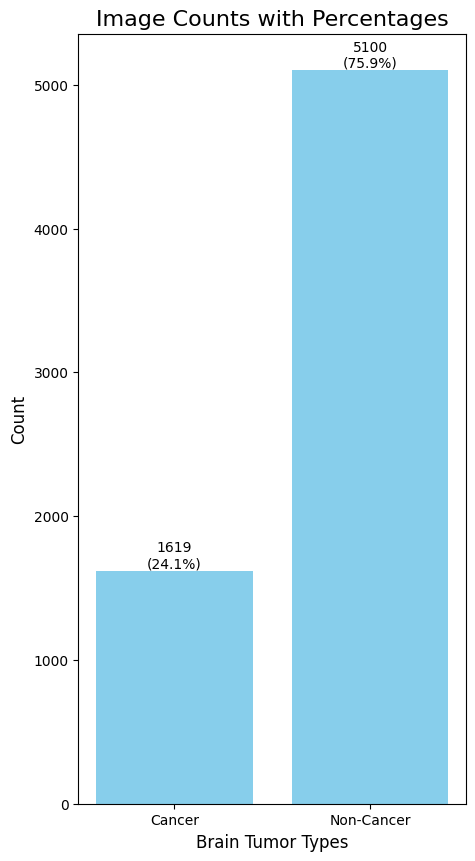

In [5]:
# Dataset 2 - 2 classes non augmented

# Load dataset
dataset = datasets.ImageFolder(root=image_dataset2_2_na_path)

# Get class distribution
class_counts = Counter(dataset.targets)

# Map indices to class names
class_names = dataset.classes

# Extract counts into variables
cancer_count_2_na = class_counts[dataset.class_to_idx['Cancer']]
noncancer_count_2_na = class_counts[dataset.class_to_idx['NonCancer']]

# Print counts
print(f"Cancer: {cancer_count_2_na}")
print(f"NonCancer: {noncancer_count_2_na}")


quick_plot_bar_graph(['Cancer', 'Non-Cancer'], [cancer_count_2_na, noncancer_count_2_na], figsize = (5, 10), title='Image Counts with Percentages', xlabel='Brain Tumor Types', ylabel='Count')

# there is a definite data imbalance with this


Glioma: 21047
Meningioma: 21242
NoTumor: 22438
Pituitary: 22620


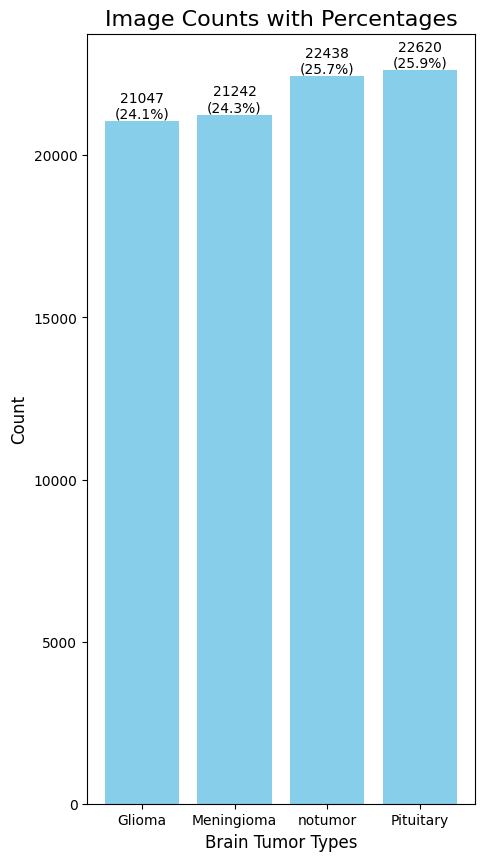

In [6]:
# Dataset 3 - 4 classes augmented

# Load dataset
dataset = datasets.ImageFolder(root=image_dataset3_4_a_path)

# Get class distribution
class_counts = Counter(dataset.targets)

# Map indices to class names
class_names = dataset.classes

# Extract counts into variables
glioma_count_4_a = class_counts[dataset.class_to_idx['glioma']]
meningioma_count_4_a = class_counts[dataset.class_to_idx['meningioma']]
notumor_count_4_a = class_counts[dataset.class_to_idx['notumor']]
pituitary_count_4_a = class_counts[dataset.class_to_idx['pituitary']]

# Print counts
print(f"Glioma: {glioma_count_4_a}")
print(f"Meningioma: {meningioma_count_4_a}")
print(f"NoTumor: {notumor_count_4_a}")
print(f"Pituitary: {pituitary_count_4_a}")

quick_plot_bar_graph(['Glioma','Meningioma','notumor','Pituitary'], [glioma_count_4_a,meningioma_count_4_a,notumor_count_4_a,pituitary_count_4_a], figsize = (5, 10), title='Image Counts with Percentages', xlabel='Brain Tumor Types', ylabel='Count')

# There is not much data imbalance so it's good to go with this data set. 

Cancer: 21047
NonCancer: 66300


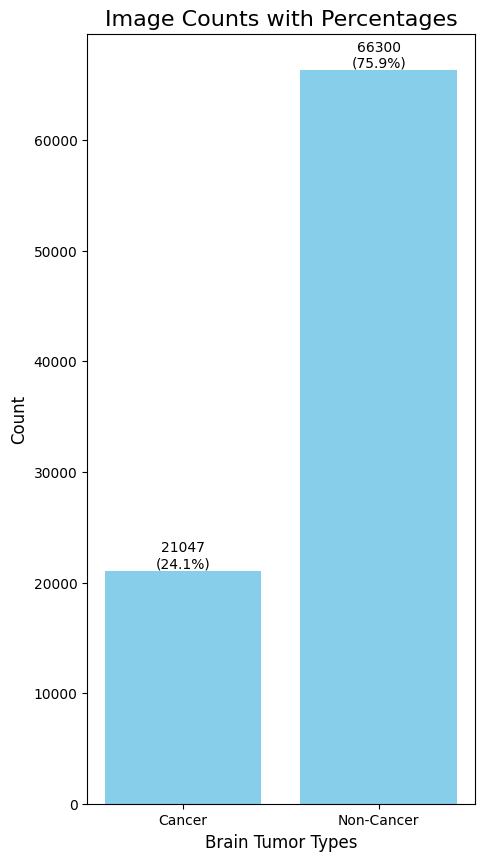

In [7]:
# Dataset 4 - 2 classes augmented

# Load dataset
dataset = datasets.ImageFolder(root=image_dataset4_2_a_path)

# Get class distribution
class_counts = Counter(dataset.targets)

# Map indices to class names
class_names = dataset.classes

# Extract counts into variables
cancer_count_2_a = class_counts[dataset.class_to_idx['Cancer']]
noncancer_count_2_a = class_counts[dataset.class_to_idx['NonCancer']]

# Print counts
print(f"Cancer: {cancer_count_2_a}")
print(f"NonCancer: {noncancer_count_2_a}")


quick_plot_bar_graph(['Cancer', 'Non-Cancer'], [cancer_count_2_a, noncancer_count_2_a], figsize = (5, 10), title='Image Counts with Percentages', xlabel='Brain Tumor Types', ylabel='Count')

# there is a definite data imbalance with this


In [8]:
# Checking the data imbalance ratio

image_imbalance_ratio = noncancer_count_2_a / cancer_count_2_a

print(f"image imbalance ratio: {image_imbalance_ratio}")

# The dataset is approximately 3:1, meaning the cancer class is underrepresented.

image imbalance ratio: 3.1500926497838173


# How many splits for Cross Validation

In [9]:
total_augmented_images = noncancer_count_2_a + cancer_count_2_a
total_nonaugmented_images = noncancer_count_2_na + cancer_count_2_na

print(f'Total number of images in augmented sample: {total_augmented_images}')
print(f'Total number of images in non augmented sample: {total_nonaugmented_images}')

Total number of images in augmented sample: 87347
Total number of images in non augmented sample: 6719


In [10]:
def amount_each_fold(folds = 5):
    print (f'number of folds: {folds}')
    augmented_images_each_folds = total_augmented_images / folds
    nonaugmented_images_each_folds = total_nonaugmented_images / folds

    print(f'augmented sample each fold: {augmented_images_each_folds}')
    print(f'non augmented sample each fold: {nonaugmented_images_each_folds}')
    print()

In [11]:
amount_each_fold(5)

amount_each_fold(10)

amount_each_fold(3)


number of folds: 5
augmented sample each fold: 17469.4
non augmented sample each fold: 1343.8

number of folds: 10
augmented sample each fold: 8734.7
non augmented sample each fold: 671.9

number of folds: 3
augmented sample each fold: 29115.666666666668
non augmented sample each fold: 2239.6666666666665



## Discovery

Looks like a good number of folds is 5 for both augmented and non augmented data

# Creating Dataloader & Folds

In [33]:
def get_transforms(augment=True, resize=(128, 128)):
    """
    Returns the transform pipeline for the dataset.

    Args:
        augment (bool): Whether to include augmentation transforms.
        resize (tuple): Target image size.

    Returns:
        transforms.Compose: Transformation pipeline.
    """
    if augment:
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure images are single-channel as all MRI are grayscaled
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.Resize(resize),
            transforms.ToTensor(),
        ])
    else:
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure images are single-channel as all MRI are grayscaled
            transforms.Resize(resize),
            transforms.ToTensor(),
        ])
    

def get_dataset(folder_path, transform):
    """
    Loads the dataset using torchvision.datasets.ImageFolder.

    Args:
        folder_path (str): Path to the dataset folder.
        transform (transforms.Compose): Transformations to apply.

    Returns:
        ImageFolder: The dataset object.
    """
    return datasets.ImageFolder(root=folder_path, transform=transform)


def calculate_class_weights(dataset):
    """
    Calculates class weights for handling class imbalance.

    Args:
        dataset (ImageFolder): The dataset object.

    Returns:
        torch.Tensor: Class weights.
    """
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    return class_weights


def create_dataloader(dataset, class_weights, batch_size=32):
    """
    Creates a DataLoader with WeightedRandomSampler to handle class imbalance.

    Args:
        dataset (ImageFolder): The dataset object.
        class_weights (torch.Tensor): Class weights for imbalance handling.
        batch_size (int): Batch size for the DataLoader.

    Returns:
        DataLoader: A PyTorch DataLoader object.
    """
    sample_weights = [class_weights[label] for _, label in dataset]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return dataloader

def split_dataset(dataset, n_splits=5):
    """
    Splits the dataset into K folds for cross-validation.

    Args:
        dataset (ImageFolder): The dataset object.
        n_splits (int): Number of folds for cross-validation.

    Returns:
        list: A list of Subset objects, one for each fold.
    """
    dataset_size = len(dataset)
    fold_size = dataset_size // n_splits
    indices = torch.randperm(dataset_size).tolist()

    folds = [
        Subset(dataset, indices[i * fold_size:(i + 1) * fold_size])
        for i in range(n_splits)
    ]

    # Handle remainder if dataset size is not perfectly divisible
    remainder = dataset_size % n_splits
    if remainder > 0:
        for i in range(remainder):
            folds[i] = Subset(dataset, indices[i * fold_size:(i + 1) * fold_size + 1])

    return folds


def get_dataset_folds(folder_path, augment_data = True, resize=(128, 128), num_splits = 5):
    transform = get_transforms(augment=augment_data,resize=resize) # augment as the data is not augmented

    # Load the dataset
    dataset = get_dataset(folder_path, transform)

    # Calculate class weights
    class_weights = calculate_class_weights(dataset)

    # Split the dataset into folds
    folds = split_dataset(dataset, n_splits= num_splits)

    return dataset, class_weights, folds 

def get_all_fold_dataloaders(class_weights, folds, batch_size=32, shuffle=True):
    """
    Generates all possible training and validation DataLoader combinations for cross-validation.

    Args:
        class_weights (torch.Tensor): Class weights for WeightedRandomSampler.
        folds (list): List of dataset subsets, one for each fold.
        batch_size (int): Batch size for DataLoaders.
        shuffle (bool): Whether to shuffle validation DataLoader.

    Returns:
        list: A list of tuples, where each tuple contains (train_loader, val_loader).
    """
    dataloaders = []

    for i in range(len(folds)):
        # Use the ith fold for validation
        validation_fold = folds[i]
        # Use the remaining folds for training
        training_folds = [folds[j] for j in range(len(folds)) if j != i]

        # Combine training folds into a single dataset
        training_dataset = torch.utils.data.ConcatDataset(training_folds)

        # Create DataLoaders
        train_loader = create_dataloader(training_dataset, class_weights, batch_size=batch_size)
        val_loader = DataLoader(validation_fold, batch_size=batch_size, shuffle=shuffle)

        dataloaders.append((train_loader, val_loader))


    '''
    How to use this function: 

    # Get all dataloaders for cross-validation (e.g., for the first dataset)
    all_dataloaders1_4_na = get_all_fold_dataloaders(class_weights1_4_na, folds1_4_na, batch_size=batch_size, shuffle=shuffle)

    # Iterate through all combinations
    for fold_idx, (train_loader, val_loader) in enumerate(all_dataloaders1_4_na):
        print(f"Fold {fold_idx + 1}:")
        print(f"Training DataLoader: {len(train_loader)} batches")
        print(f"Validation DataLoader: {len(val_loader)} batches")
    '''
    
    return dataloaders


In [32]:
# apply to all the datasets
resize = (256, 256)
num_splits = 5

batch_size= 32
shuffle = True

In [34]:
# Dataloader 1 - 4 classes non augmented

dataset1_4_na, class_weights1_4_na, folds1_4_na = get_dataset_folds(image_dataset1_4_na_path, augment_data = True, resize=resize, num_splits = num_splits) 
# augment as the data is not augmented

all_dataloaders1_4_na = get_all_fold_dataloaders(class_weights1_4_na, folds1_4_na, batch_size=batch_size, shuffle=shuffle)

In [35]:
# Dataloader 2 - 2 classes non augmented

dataset2_2_na, class_weights2_2_na, folds2_2_na = get_dataset_folds(image_dataset2_2_na_path, augment_data = True, resize=resize, num_splits = num_splits) 
# augment as the data is not augmented

all_dataloaders2_2_na = get_all_fold_dataloaders(class_weights2_2_na, folds2_2_na, batch_size=batch_size, shuffle=shuffle)

In [36]:
# Dataloader 3 - 4 classes augmented

dataset3_4_a, class_weights3_4_a, folds3_4_a = get_dataset_folds(image_dataset3_4_a_path, augment_data = False, resize=resize, num_splits = num_splits) 
# No augment as the data is already 

all_dataloaders3_4_a = get_all_fold_dataloaders(class_weights3_4_a, folds3_4_a, batch_size=batch_size, shuffle=shuffle)

In [37]:
# Dataloader 4 - 2 classes augmented

dataset4_2_a, class_weights4_2_a, folds4_2_a = get_dataset_folds(image_dataset4_2_a_path, augment_data = False, resize=resize, num_splits = num_splits) 
# No augment as the data is already 

all_dataloaders4_2_a = get_all_fold_dataloaders(class_weights4_2_a, folds4_2_a, batch_size=batch_size, shuffle=shuffle)

# Defining the CNN Model

In [38]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # For grayscale input
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # Adjust dimensions based on your input size
        self.fc2 = nn.Linear(128, num_classes) # num_classes = number of output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# The `forward` method defines how the model processes input data and generates output.
# You do not call the `forward` method directly; instead, you call the model, which internally calls `forward`.

# Set Up Training and Validation Loop

In [39]:
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cuda'):
    """
    Train and validate the CNN model.

    Args:
        model (nn.Module): The CNN model.
        criterion (Loss): Loss function.
        optimizer (Optimizer): Optimizer.
        train_loader (DataLoader): Training DataLoader.
        val_loader (DataLoader): Validation DataLoader.
        num_epochs (int): Number of training epochs.
        device (str): Device to run the model on ('cuda' or 'cpu').

    Returns:
        nn.Module: Trained model.
    """
    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        print(f"Validation Loss: {val_loss / len(val_loader)}")
        print(classification_report(y_true, y_pred))

    return model


# Setting GPU or CPU

In [41]:
# check if your GPU supports CUDA

if torch.cuda.is_available():
    print('cuda IS available')
else:
    print('cuda IS NOT available')


cuda IS available


In [42]:
# GPU is available, so we will use it for training the model.

device = 'cuda'

# Perform K-Fold Cross Validation

In [44]:
# Dataset1_4_na

num_classes = len(dataset1_4_na.classes)  # Number of classes in the dataset

all_dataloaders1_4_na = get_all_fold_dataloaders(class_weights1_4_na, folds1_4_na, batch_size=batch_size, shuffle=shuffle)

# Initialize the model, loss function, and optimizer
model = SimpleCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for fold_idx, (train_loader, val_loader) in enumerate(all_dataloaders1_4_na):
    print(f"Training Fold {fold_idx + 1}/{len(all_dataloaders1_4_na)}")
    model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device=device)


Training Fold 1/5


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1048576 and 262144x128)

# Evaluate Across Folds

In [ ]:
# Collect results across all folds
overall_y_true = []
overall_y_pred = []

for fold_idx, (train_loader, val_loader) in enumerate(all_dataloaders1_4_na):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    overall_y_true.extend(y_true)
    overall_y_pred.extend(y_pred)

# Classification report for the aggregated results
print(classification_report(overall_y_true, overall_y_pred))


# Save Model

In [ ]:
# Save the model
torch.save(model.state_dict(), f"model_fold_{fold_idx + 1}.pth")


# Load Model

In [ ]:
# Load the model (if needed)
model.load_state_dict(torch.load("model_fold_1.pth"))
model.eval()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

'''
nn.Conv2d - input features, output features, kernel window like 3x3, stride, padding
'''

class SimpleCNN(nn.Module):
    def __init__(self, num_output_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0) # input features are RGP channels, and 32 are ouutput features
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 64  * 64 , 128)  # 1st is 64 features / filters, 2nd 64 is height of image, 3rd 64 is the width of image, the 128 is the output 
        self.fc2 = nn.Linear(128, num_output_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Example CNN from scratch
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Feature extractor (convolutional layers)
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # output: 16 x 112 x 112

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # output: 32 x 56 x 56

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # output: 64 x 28 x 28
        )
        
        # Classifier (fully-connected layers)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)  # num_classes=2 for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        # Flatten the output of the convolutional layers
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Model Parameters

In [ ]:
# Choose your device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Instantiate the model
model = SimpleCNN(num_classes=2)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # good for multi-class or binary with 'num_classes=2'
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Hyper parameters

# Training

In [ ]:
num_epochs = 10  # change as you see fit

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Move data to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item() * images.size(0)
        
        # Calculate training accuracy in this batch
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


# Future Scope

I will need to figure out a better way to organize and manipulate data while not using so many duplicate folders. If the image data set is large, then all this duplication and augmentation will really explode the memory.